In [ ]:
import csv
import time
import serial
import threading
import keyboard
from pylsl import StreamInlet, resolve_byprop, local_clock

def run_ldr_recording(num_block='test101', port='COM5', baudrate=115200):
    # === Initialize Serial ===
    try:
        ser = serial.Serial(port, baudrate, timeout=1)
        print(f"Connected to {port} at {baudrate} baud.")
    except serial.SerialException as e:
        print(f"Error opening serial port: {e}")
        return

    # === Globals ===
    ldr_data = []
    markers_applied = []
    raw_marker_data = []
    raw_ldr_data = []
    stop_event = threading.Event()
    block_started = False
    latest_ldr_index = -1
    arduino_start_time = None
    lsl_time_at_start = None
    start_relative_time = None
    ldr_lock = threading.Lock()
    last_arduino_time = None
    overflow_offset = 0
    MAX_MICROS = 2**32

    # === Marker Thread ===
    def marker_stream_listener():
        nonlocal block_started, lsl_time_at_start, latest_ldr_index

        print("Looking for marker stream...")
        # streams = resolve_byprop('type', 'Markers', timeout=10)   
        streams = resolve_byprop('type', 'Markers')    

        if not streams:
            print("No LSL marker stream found.")
            stop_event.set()
            return

        inlet = StreamInlet(streams[0])
        print("Connected to LSL! Waiting for markers...")

        while not stop_event.is_set():
            sample, timestamp = inlet.pull_sample()
            if sample:
                trigger = sample[0]
                if lsl_time_at_start is None:
                    lsl_time_at_start = local_clock()
                    print(f"[SYNC] LSL time reference: {lsl_time_at_start:.6f} s")

                print(f"[Marker] Received: {trigger}")

                with ldr_lock:
                    if 0 <= latest_ldr_index < len(ldr_data):
                        old_ts, old_val, _ = ldr_data[latest_ldr_index]
                        ldr_data[latest_ldr_index] = (old_ts, old_val, trigger)
                        markers_applied.append((trigger, old_ts))

                raw_marker_data.append((timestamp, trigger))

                if trigger == 'Start Block':
                    block_started = True
                    print(f"== Start Block {num_block} ==")

                if trigger == 'End Block':
                    block_started = False
                    print(f"== End Block {num_block} ==")
                    stop_event.set()
                    break

    # === LDR Thread ===
    def read_ldr():
        nonlocal block_started, ser
        nonlocal arduino_start_time, lsl_time_at_start, start_relative_time, latest_ldr_index
        nonlocal last_arduino_time, overflow_offset

        while not stop_event.is_set():
            if block_started and ser and ser.in_waiting:
                try:
                    data = ser.readline().strip()
                    parts = data.split(b',')
                    if len(parts) == 2:
                        raw_time = float(parts[0])
                        ldr_value = parts[1].decode('latin-1')

                        if last_arduino_time is not None and raw_time < last_arduino_time:
                            overflow_offset += MAX_MICROS
                        last_arduino_time = raw_time
                        arduino_time = raw_time + overflow_offset

                        if arduino_start_time is None:
                            arduino_start_time = arduino_time
                            lsl_time_at_start = local_clock()
                            print(f"[SYNC] Arduino time: {arduino_start_time} µs, LSL: {lsl_time_at_start:.6f} s")

                        delta_sec = (arduino_time - arduino_start_time) / 1_000_000.0
                        aligned_time = lsl_time_at_start + delta_sec

                        if start_relative_time is None:
                            start_relative_time = aligned_time

                        relative_time = aligned_time - start_relative_time

                        with ldr_lock:
                            ldr_data.append((relative_time, ldr_value, ''))
                            latest_ldr_index = len(ldr_data) - 1

                        raw_ldr_data.append((raw_time, ldr_value))
                    else:
                        print(f"[WARN] Invalid format: {data}")
                except Exception as e:
                    print(f"[ERROR] {e} from data: {data}")

    # === ESC Listener ===
    def check_for_esc():
        while not stop_event.is_set():
            if keyboard.is_pressed('esc'):
                print("ESC pressed. Stopping...")
                stop_event.set()
            time.sleep(0.1)

    # Save Functions
    def save_data_to_csv():
        # Process 
        process_name = 'block_' + num_block + '_process.csv'
        with open(process_name, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Time (s from start)', 'LDR Value', 'Marker'])
            for ts, val, label in ldr_data:
                writer.writerow([f"{ts:.6f}", val, label])
        print(f"Saved LDR to {process_name}")

        # Marker
        marker_name = 'block_' + num_block + '_marker.csv'
        with open(marker_name, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Marker Label', 'Time (s from start)'])
            for label, ts in markers_applied:
                writer.writerow([label, f"{ts:.6f}"])
        print(f"Saved markers to {marker_name}")

        # Raw data
        raw_name = 'block_' + num_block + '_raw.csv'
        with open(raw_name, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Timestamp', 'Value', 'Type'])
            for ts, val in raw_ldr_data:
                writer.writerow([f"{ts:.6f}", val, 'LDR'])
            for ts, trigger in raw_marker_data:
                writer.writerow([f"{ts:.6f}", trigger, 'Marker'])
        print(f"Saved raw data to {raw_name}")

    # Start Threads
    listener_thread = threading.Thread(target=marker_stream_listener)
    ldr_thread = threading.Thread(target=read_ldr)
    esc_thread = threading.Thread(target=check_for_esc, daemon=True)

    listener_thread.start()
    ldr_thread.start()
    esc_thread.start()

    listener_thread.join()
    ldr_thread.join()

    print(f"\n[SUMMARY] Collected {len(ldr_data)} LDR samples and {len(markers_applied)} markers.")

    save_data_to_csv()

    if ser:
        ser.close()


In [3]:
run_ldr_recording(num_block=str(1))

Connected to COM5 at 115200 baud.
Looking for marker stream...
Connected to LSL! Waiting for markers...
[SYNC] LSL time reference: 435670.319405 s
[Marker] Received: Start Block
== Start Block 1 ==
[SYNC] Arduino time: 2216.0 µs, LSL: 435670.321220 s
[Marker] Received: trial_1
[Marker] Received: end_1
[Marker] Received: trial_2
[Marker] Received: end_2
[Marker] Received: trial_3
[Marker] Received: end_3
[Marker] Received: trial_4
[Marker] Received: end_4
[Marker] Received: trial_5
[Marker] Received: end_5
[Marker] Received: trial_6
[Marker] Received: end_6
[Marker] Received: trial_7
[Marker] Received: end_7
[Marker] Received: trial_8
[Marker] Received: end_8
[Marker] Received: trial_9
[Marker] Received: end_9
[Marker] Received: trial_10
[Marker] Received: end_10
[Marker] Received: trial_11
[Marker] Received: end_11
[Marker] Received: trial_12
[Marker] Received: end_12
[Marker] Received: trial_13
[Marker] Received: end_13
[Marker] Received: trial_14
[Marker] Received: end_14
[Marker] Re

In [12]:
for i in range(1,4):
    # print(i)
    run_ldr_recording(num_block=str(i))

Connected to COM5 at 115200 baud.
Looking for marker stream...
Connected to LSL! Waiting for markers...
[SYNC] LSL time reference: 436446.841110 s
[Marker] Received: end_1
[Marker] Received: Start Block
== Start Block 1 ==
[ERROR] could not convert string to float: b'' from data: b',197'
[SYNC] Arduino time: 30354120.0 µs, LSL: 436473.865244 s
[WARN] Invalid format: b'38724120,0,150'
[Marker] Received: trial_1
[Marker] Received: end_1
[Marker] Received: trial_2
[Marker] Received: end_2
[Marker] Received: trial_3
[Marker] Received: end_3
[Marker] Received: trial_4
[Marker] Received: end_4
[Marker] Received: trial_5
[Marker] Received: end_5
[Marker] Received: trial_6
[Marker] Received: end_6
[Marker] Received: trial_7
[Marker] Received: end_7
[Marker] Received: trial_8
[Marker] Received: end_8
[Marker] Received: trial_9
[Marker] Received: end_9
[Marker] Received: trial_10
[Marker] Received: end_10
[Marker] Received: trial_11
[Marker] Received: end_11
[Marker] Received: trial_12
[Marker] 

In [ ]:
import pandas as pd
df = pd.read_csv('raw_1.csv')
marker_row = df[df['Type'] == 'Marker']
total_trials = 64
missing = []

for i in range(1, total_trials + 1):
    if f"trial_{i}" not in marker_row.values:
        missing.append(f"trial_{i}")
    if f"end_{i}" not in marker_row.values:
        missing.append(f"end_{i}")
if missing:
    print("Missing markers:")
    for m in missing:
        print(f"  - {m}")
else:
    print("All markers present.")
    
    
start_marker = marker_row[marker_row['Value'].str.contains('Start Block', case=False)]
end_marker = marker_row[marker_row['Value'].str.contains('End Block', case=False)]

init_time = (start_marker['Timestamp'].values[0])
end_time = (end_marker['Timestamp'].values[0])

# Align start time  
marker_aligned = marker_row.copy()
marker_aligned['Timestamp'] = marker_row['Timestamp'] - init_time

ldr_row = df[df['Type'] == 'LDR']
start_time = ldr_row['Timestamp'].values[0]

ldr_rows_aligned = ldr_row.copy()
ldr_rows_aligned['Timestamp'] = ((ldr_row['Timestamp'] - start_time))/1e6 


All markers present.


In [ ]:
import numpy as np
# --- Step 1: Split Data ---
marker_row = df[df['Type'] == 'Marker'].copy()
ldr_row = df[df['Type'] == 'LDR'].copy()

# --- Step 2: Check for missing trial markers ---
total_trials = 64
missing = []
for i in range(1, total_trials + 1):
    if f"trial_{i}" not in marker_row['Value'].values:
        missing.append(f"trial_{i}")
    if f"end_{i}" not in marker_row['Value'].values:
        missing.append(f"end_{i}")

if missing:
    print("Missing markers:")
    for m in missing:
        print(f"  - {m}")
else:
    print("All markers present.")

# --- Step 3: Align timestamps ---
# Get start and end block timestamps from Marker
start_marker = marker_row[marker_row['Value'].str.contains('Start Block', case=False)]
end_marker = marker_row[marker_row['Value'].str.contains('End Block', case=False)]

# Use Start Block as reference zero point
init_time = start_marker['Timestamp'].values[0]
end_time = end_marker['Timestamp'].values[0]

# Align marker timestamps (relative to start block)
marker_aligned = marker_row.copy()
marker_aligned['Timestamp'] = marker_aligned['Timestamp'] - init_time

# Align LDR timestamps (relative to first LDR sample)
ldr_rows_aligned = ldr_row.copy()
ldr_rows_aligned['Timestamp'] = (ldr_rows_aligned['Timestamp'] - ldr_rows_aligned['Timestamp'].iloc[0]) / 1e6  # Convert µs to sec


ldr_marker = ldr_rows_aligned.copy()
ldr_marker['Marker'] = None

ldr_marker = ldr_marker.dropna(subset=['Timestamp', 'Value']).copy()
ldr_marker = ldr_marker.reset_index(drop=True)

ldr_times = ldr_marker['Timestamp'].values

for _, row in marker_aligned.iterrows():
    marker_time = row['Timestamp']
    label = row['Value']

    idx = np.argmin(np.abs(ldr_times - marker_time))
    ldr_marker.at[idx, 'Marker'] = label
    
ldr_marker_cleaned = ldr_marker.drop(columns=['Type']).reset_index(drop=True)
ldr_marker_cleaned = ldr_marker_cleaned.rename(columns={
    'Timestamp': 'Time (s from start)',
    'Value': 'LDR Value'
})
ldr_marker_cleaned.to_csv('ldr_aligned_with_marker.csv', index=False)


All markers present.


In [ ]:
import process_freq as func
# Load Data
filename = 'ldr_aligned_with_marker.csv' 
df = pd.read_csv(filename)
df = func.preprocess_ldr(df)

# Configuration
monitor_frequency = 60  
sr = 500    # Photocell Sampling rate
threshold = 300     # Photocell threshold

n_trial = 64
n_block = 18

All markers present.


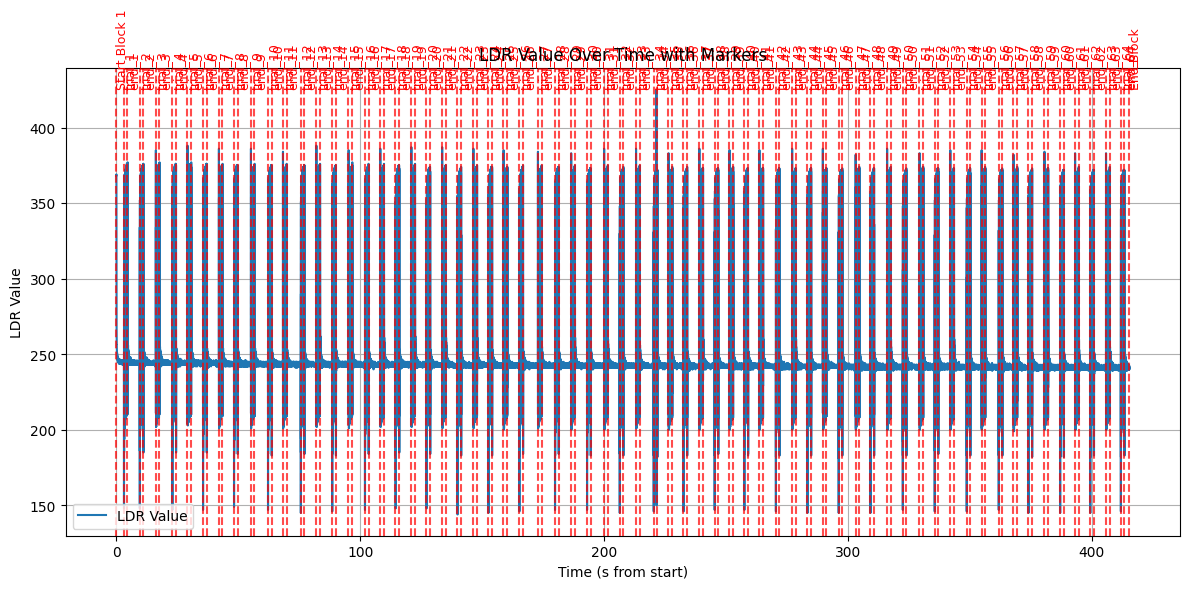

In [200]:
# Overall check 
func.check_missing_marker(df, total_trials=n_trial)   # Missing trial marker check
func.plot_ldr_data_with_markers(df=df)  # plot all photocell_value-marker

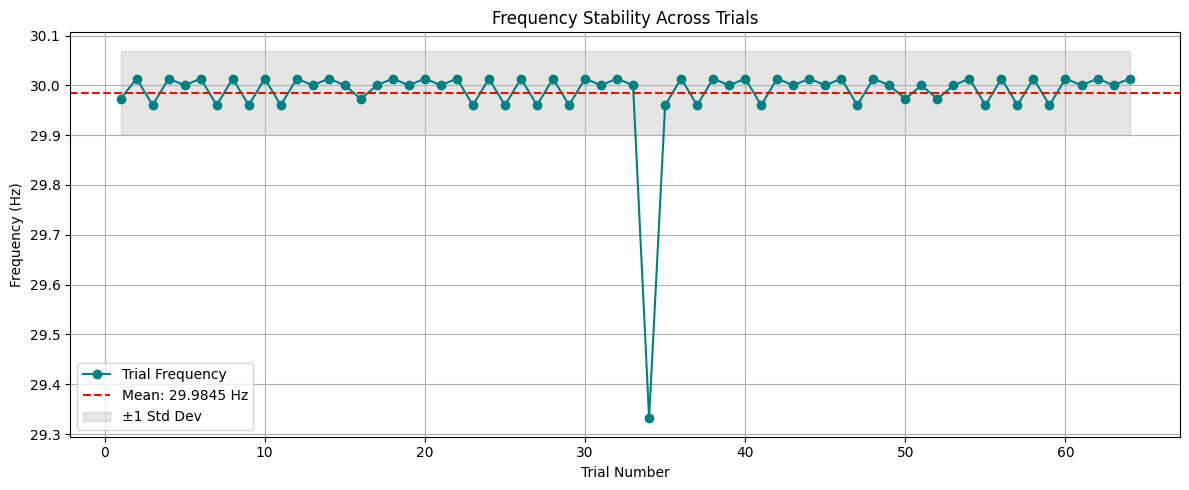

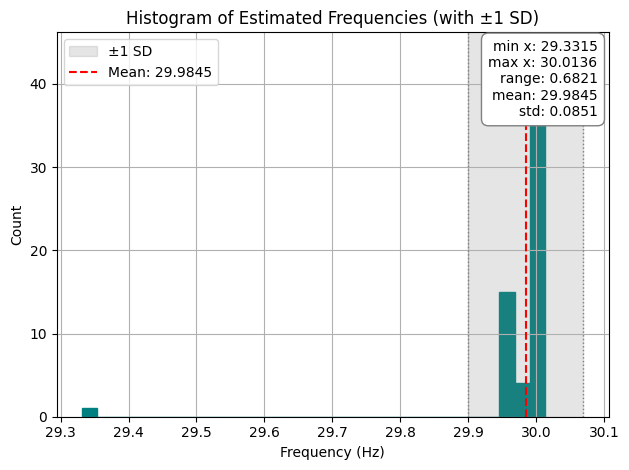

In [201]:
trial_labels, freqs = func.collect_frequencies(df,num_trial=n_trial, monitor_freq=monitor_frequency, sr=sr,threshold=threshold)
func.plot_frequency_stability(trial_labels, freqs)
func.plot_hist_freq(freqs=freqs)

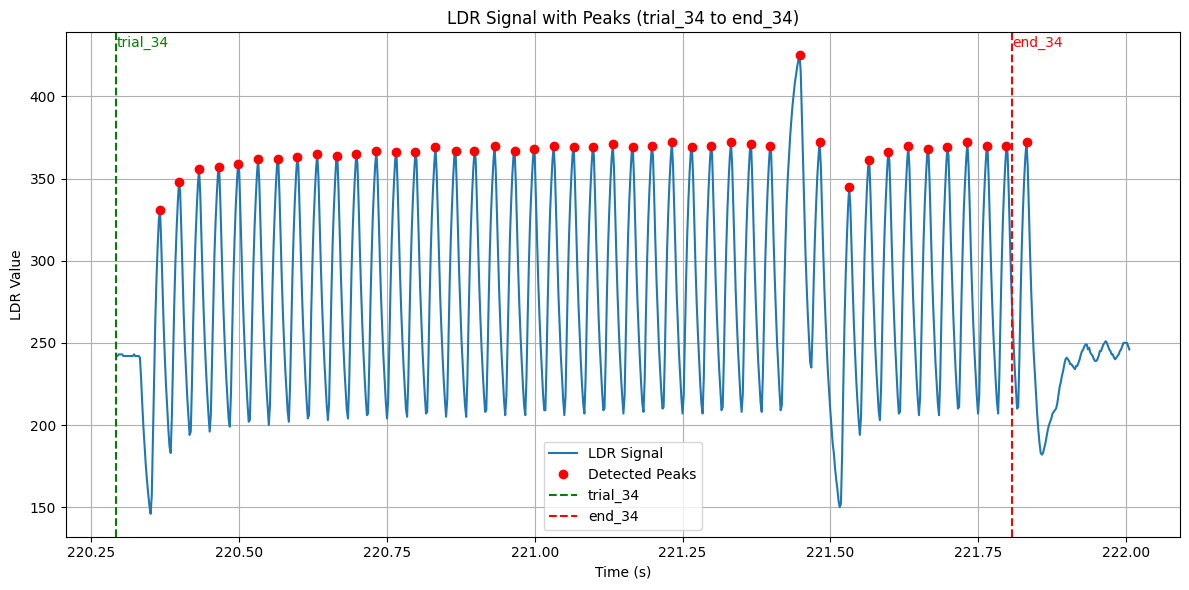

Frequency: 29.3315 Hz, Peaks: 44, Est. Period: 0.0341 sec


In [204]:
func.plot_peaks_in_segment(df, 'trial_34', 'end_34', distance=15, height=300)